# Uvod #

U ovoj ćete vježbi dodati ispadanje *Spotify* modelu iz prethnodne vježbe i vidjeti kako vam skupna normalizacija može omogućiti uspješno treniranje modela na teškim skupovima podataka.

Pokrenite sljedeću ćeliju da biste započeli!

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')



Prvo učitajte skup podataka *Spotify*.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./input/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


# 1) Dodajte dropout Spotify modelu

Ovdje je posljednji model iz prethnodne vježbe. Dodajte dva ispadajuća sloja, jedan nakon sloja `Dense` sa 128 jedinica i jedan nakon sloja `Dense` sa 64 jedinice. Postavite stopu ispadanja na oba na "0.3".

In [3]:
# YOUR CODE HERE: Add two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

c:\Users\ASUS\Desktop\PSU-lab\Lab3_online\psu\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Sada pokrenite ovu sljedeću ćeliju da uvježbate model i vidite učinak dodavanja ispadanja.

Minimum Validation Loss: 0.1877


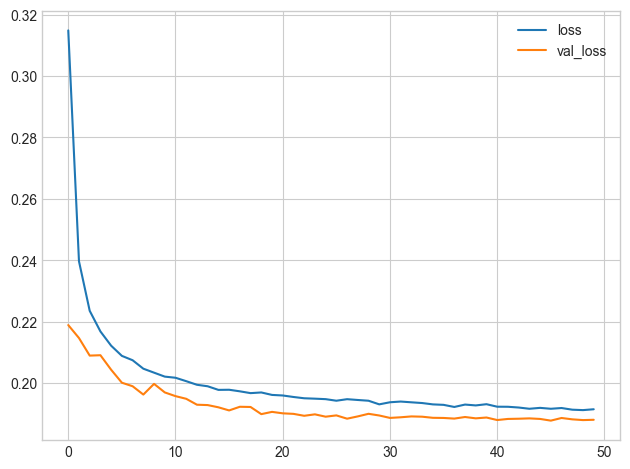

In [4]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# 2) Procijenite odustajanje

Prisjetite se da je ovaj model imao tendenciju pretjeranog prilagođavanja podataka oko epohe 5. Je li se činilo da dodavanje ispadanja ovaj put pomaže u sprječavanju pretjeranog prilagođavanja?
#
ODGOVOR:Da

Sada ćemo promijeniti temu da istražimo kako serijska normalizacija može riješiti probleme u obuci.

Učitajte skup podataka *Concrete*. Ovaj put nećemo raditi nikakvu standardizaciju. To će učinak normalizacije serije učiniti puno očiglednijim.

In [5]:
import pandas as pd

concrete = pd.read_csv('./input/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Pokrenite sljedeću ćeliju kako biste uvježbali mrežu na nestandardiziranim *Concrete* podacima.

c:\Users\ASUS\Desktop\PSU-lab\Lab3_online\psu\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: nan


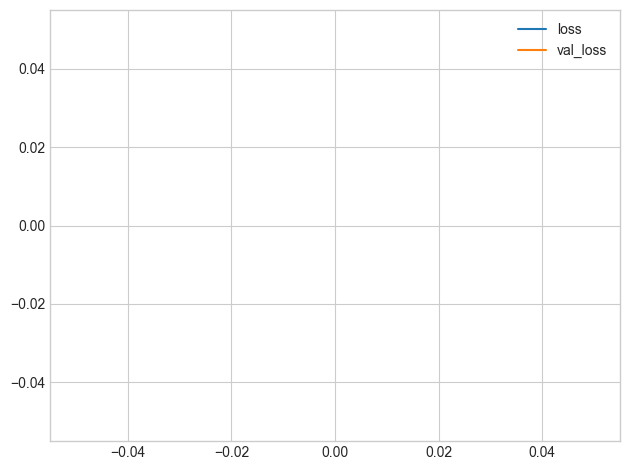

In [6]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Jeste li završili s praznim grafikonom? Pokušaj treniranja ove mreže na ovom skupu podataka obično neće uspjeti. Čak i kada konvergira (zbog sretne inicijalizacije težine), ima tendenciju konvergirati na vrlo veliki broj.

# 3) Dodajte slojeve normalizacije serije

Skupna normalizacija može pomoći u ispravljanju ovakvih problema.

Dodajte četiri sloja `BatchNormalization`, jedan prije svakog od gustih slojeva. (Ne zaboravite premjestiti argument `input_shape` na novi prvi sloj.)

In [7]:
# YOUR CODE HERE: Add a BatchNormalization layer before each Dense layer
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])


c:\Users\ASUS\Desktop\PSU-lab\Lab3_online\psu\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Pokrenite sljedeću ćeliju da vidite hoće li nam skupna normalizacija omogućiti treniranje modela.

Minimum Validation Loss: 3.9271


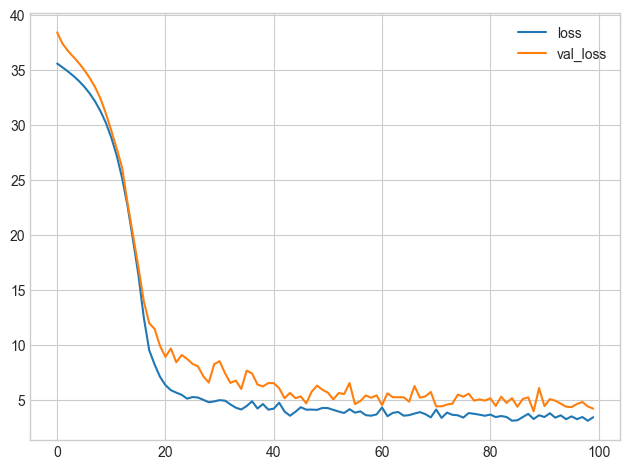

In [8]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

# 4) Procijenite normalizaciju serije

Je li dodavanje normalizacije serije pomoglo?
#
Da


# Nastavi #

[**Kreiraj neuralnu mežu**](Binary_Classification_hr.ipynb) za binarnu klasifikaciju.